# NBA Rookie Career Prediction - Data Collection
by Kevin Götz

## Table of Contents

1. Basic Information on the Data Source
2. Import Modules & DB Setup
3. NBA Database Exploration & Collection
4. Web Scraping of NBA Player Performance Data
5. Web Scraping of League Average Data
6. Combination of Data Sources
7. Separate Rookies from Veterans for Training & Prediction

## 1. Basic Information on the Data Sources

Two different data sources were combined:

1. The [Database (Kaggle)](https://www.kaggle.com/wyattowalsh/basketball) is from Wyatt Walsh. It gets updated daily and contains data on all games, all teams, and all players within the NBA including:<br/>Box scores, Game summaries, Officials, Season series info, General team details (stadium, head coach, general manager, social media links, etc), NBA Combine, etc. <br/><br/>
    
2. The additional player performance stats are from the crawled website ["basketball-reference.com"](https://www.basketball-reference.com) and list a plethora of stats, such as GS, MP, FG,	FGA, FG%, 3P 	3PA, 3P%, 2P, 2PA, 2P%, ORB, DRB, STL ... & more. <br/> See [Lebron James](https://www.basketball-reference.com/players/j/jamesle01.html) for example. Also the [League Averages per Season](https://www.basketball-reference.com/leagues/NBA_stats_per_game.html) were crawled on this website.


## 2. Import Modules & DB Setup

In [1]:
# check if Kernel is the correct virtual environment (venv)
!where python

C:\Users\Kevin G�tz\venv\nba_rookie\Scripts\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python39\python.exe
C:\Users\Kevin G�tz\AppData\Local\Microsoft\WindowsApps\python.exe


In [13]:
# Import modules

# Data Munging
import pandas as pd 
pd.set_option('display.max.columns', None)
pd.set_option('display.precision', 2)
import numpy as np 

# Database
import sqlite3

# Web Scraping
import requests
from bs4 import BeautifulSoup
import sys
from unidecode import unidecode

# Viz
from matplotlib import pyplot as plt 
%matplotlib inline


In [116]:
# DB Setup

# Create and Connect to Database & Setup SQL-Magic
%load_ext sql

# Set autocommit for DDL commands
%config SqlMagic.autocommit=True

# Return Pandas DataFrames instead of regular result sets (otherwise .DataFrame() would do it)
%config SqlMagic.autopandas=True

# don't show DB feedback ("Done.")
%config SqlMagic.feedback=False

# don't show DB connection after every DB call
%config SqlMagic.displaycon=False

 # Filepath or URI (if Cloud); connects if exists and creates if doesn't exist
filepath = 'sqlite:///..//Data/Input/basketball.sqlite'
%sql sqlite:///..//Data/Input/basketball.sqlite

# Test the Connection
connections = %sql -l
print(f'List of active connections: {connections}')

# to close connections
# [c.session.close() for c in connections.values()]

List of active connections: {'sqlite:///..//Data/Input/basketball.sqlite': <sql.connection.Connection object at 0x0000016D984735E0>}


## 3. NBA Database Exploration & Collection

- Exploration of the Database
- Exploration of the Tables in the Database
- Collection & Combination of Different Player Attributes

In [10]:
# lets see the tables in the DB

table_names = %sql select name from sqlite_master where type='table';
table_names

,name
0,Team
1,Team_Attributes
2,Team_History
3,Player_Attributes
4,Game_Officials
5,Game_Inactive_Players
6,Team_Salary
7,Player_Salary
8,Draft
9,Draft_Combine


In [11]:
# print a quick preview for every table

for table_name in table_names.squeeze().tolist():
    table = %sql select * from {table_name};
    print(f'Summary for table "{table_name}":')
    print(f'columns: {table.shape[1]}')
    print(f'rows: {table.shape[0]}')
    display(table.head(3))

Summary for table "Team":
columns: 7
rows: 30


,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970


Summary for table "Team_Attributes":
columns: 14
rows: 30


,ID,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION,FACEBOOK_WEBSITE_LINK,INSTAGRAM_WEBSITE_LINK,TWITTER_WEBSITE_LINK
0,1610612737,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Nate McMillan,Erie Bayhawks,https://www.facebook.com/hawks,https://instagram.com/atlhawks,https://twitter.com/ATLHawks
1,1610612738,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws,https://www.facebook.com/bostonceltics,https://instagram.com/celtics,https://twitter.com/celtics
2,1610612739,CLE,Cavaliers,1970,Cleveland,Rocket Mortgage FieldHouse,20562.0,Dan Gilbert,Koby Altman,JB Bickerstaff,Canton Charge,https://www.facebook.com/Cavs,https://instagram.com/cavs,https://twitter.com/cavs


Summary for table "Team_History":
columns: 5
rows: 60


,ID,CITY,NICKNAME,YEARFOUNDED,YEARACTIVETILL
0,1610612737,Atlanta,Hawks,1968,2019
1,1610612737,St. Louis,Hawks,1955,1967
2,1610612737,Milwaukee,Hawks,1951,1954


Summary for table "Player_Attributes":
columns: 37
rows: 4500


,ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,GAMES_PLAYED_CURRENT_SEASON_FLAG,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
0,76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24T00:00:00,Duke,USA,Duke/USA,82.0,240.0,4,30,Forward,Inactive,N,1610612757,Trail Blazers,POR,blazers,Portland,HISTADD_alaa_abdelnaby,1990,1994,N,Y,Y,1990,1,25,5.7,0.3,3.3,0.0,NaN
1,76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07T00:00:00,Iowa State,USA,Iowa State/USA,81.0,235.0,9,54,Center,Inactive,N,1610612745,Rockets,HOU,rockets,Houston,HISTADD_zaid_abdul-aziz,1968,1977,N,Y,Y,1968,1,5,9.0,1.2,8.0,0.0,NaN
2,76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16T00:00:00,UCLA,USA,UCLA/USA,86.0,225.0,19,33,Center,Inactive,N,1610612747,Lakers,LAL,lakers,Los Angeles,HISTADD_kareem_abdul-jabbar,1969,1988,N,Y,Y,1969,1,1,24.6,3.6,11.2,18.0,NaN


Summary for table "Game_Officials":
columns: 5
rows: 65158


,OFFICIAL_ID,FIRST_NAME,LAST_NAME,JERSEY_NUM,GAME_ID
0,1165,Luis,Grillo,8,0029600059
1,1140,Bruce,Alexander,9,0029600059
2,1153,Joe,Crawford,17,0029600059


Summary for table "Game_Inactive_Players":
columns: 9
rows: 98679


,PLAYER_ID,FIRST_NAME,LAST_NAME,JERSEY_NUM,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,GAME_ID
0,184,Bobby,Phills,14,1610612739,Cleveland,Cavaliers,CLE,0029600034
1,781,Will,Perdue,41,1610612759,San Antonio,Spurs,SAS,0029600034
2,120,Steven,Smith,8,1610612737,Atlanta,Hawks,ATL,0029600132


Summary for table "Team_Salary":
columns: 9
rows: 30


,nameTeam,slugTeam,urlTeamSalaryHoopsHype,X2020-21,X2021-22,X2022-23,X2023-24,X2024-25,X2025-26
0,Atlanta Hawks,ATL,http://hoopshype.com/salaries/atlanta_hawks/,1.19e+08,9.55e+07,5.97e+07,1.80e+07,0.00e+00,0.00e+00
1,Boston Celtics,BOS,http://hoopshype.com/salaries/boston_celtics/,1.32e+08,1.32e+08,9.56e+07,6.20e+07,3.48e+07,3.71e+07
2,Brooklyn Nets,BKN,http://hoopshype.com/salaries/brooklyn_nets/,1.69e+08,1.66e+08,1.57e+08,1.99e+07,0.00e+00,0.00e+00


Summary for table "Player_Salary":
columns: 12
rows: 1292


,slugSeason,nameTeam,namePlayer,statusPlayer,isFinalSeason,isWaived,isOnRoster,isNonGuaranteed,isTeamOption,isPlayerOption,typeContractDetail,value
0,2020-21,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,1.80e+07
1,2021-22,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,1.80e+07
2,2022-23,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,1.80e+07


Summary for table "Draft":
columns: 16
rows: 7890


,yearDraft,numberPickOverall,numberRound,numberRoundPick,namePlayer,slugTeam,nameOrganizationFrom,typeOrganizationFrom,idPlayer,idTeam,nameTeam,cityTeam,teamName,PLAYER_PROFILE_FLAG,slugOrganizationTypeFrom,locationOrganizationFrom
0,2020.0,1.0,1.0,1.0,Anthony Edwards,MIN,Georgia,College/University,1.63e+06,1.61e+09,Minnesota Timberwolves,Minnesota,Timberwolves,1.0,COL,None
1,2020.0,2.0,1.0,2.0,James Wiseman,GSW,Memphis,College/University,1.63e+06,1.61e+09,Golden State Warriors,Golden State,Warriors,1.0,COL,None
2,2020.0,3.0,1.0,3.0,LaMelo Ball,CHA,Illawarra,Other Team/Club,1.63e+06,1.61e+09,Charlotte Hornets,Charlotte,Hornets,1.0,PRO,Australia


Summary for table "Draft_Combine":
columns: 116
rows: 1395


,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,heightWOShoes,weightLBS,wingspanInches,wingspan,reachStandingInches,reachStandingO,verticalLeapStandingInches,verticalLeapMaxInches,timeLaneAgility,timeThreeQuarterCourtSprint,repsBenchPress135,pctBodyFat,heightWShoesInches,heightWShoes,lengthHandInches,widthHandInches,timeModifiedLaneAgility,setSpot15CornerLeft,setSpot15BreakLeft,setSpot15TopKey,setSpot15BreakRight,setSpot15CornerRight,setSpot15CornerLeftCollege,setSpot15BreakLeftCollege,setSpot15TopKeyCollege,setSpot15BreakRightCollege,setSpot15CornerRightCollege,setSpot15CornerLeftNBA,setSpot15BreakLeftNBA,setSpot15TopKeyNBA,setSpotBreakRightNBA,setSpotCornerRightNBA,setSpot15CornerLeftMade,setSpot15CornerLeftAttempted,setSpot15CornerLeftPct,setSpot15BreakLeftMade,setSpot15BreakLeftAttempted,setSpot15BreakLeftPct,setSpot15TopKeyMade,setSpot15TopKeyAttempted,setSpot15TopKeyPct,setSpot15BreakRightMade,setSpot15BreakRightAttempted,setSpot15BreakRightPct,setSpot15CornerRightMade,setSpot15CornerRightAttempted,setSpot15CornerRightPct,setSpot15CornerLeftCollegeMade,setSpot15CornerLeftCollegeAttempted,setSpot15CornerLeftCollegePct,setSpot15BreakLeftCollegeMade,setSpot15BreakLeftCollegeAttempted,setSpot15BreakLeftCollegePct,setSpot15TopKeyCollegeMade,setSpot15TopKeyCollegeAttempted,setSpot15TopKeyCollegePct,setSpot15BreakRightCollegeMade,setSpot15BreakRightCollegeAttempted,setSpot15BreakRightCollegePct,setSpot15CornerRightCollegeMade,setSpot15CornerRightCollegeAttempted,setSpot15CornerRightCollegePct,setSpot15CornerLeftNBAMade,setSpot15CornerLeftNBAAttempted,setSpot15CornerLeftNBAPct,setSpot15BreakLeftNBAMade,setSpot15BreakLeftNBAAttempted,setSpot15BreakLeftNBAPct,setSpot15TopKeyNBAMade,setSpot15TopKeyNBAAttempted,setSpot15TopKeyNBAPct,setSpotBreakRightNBAMade,setSpotBreakRightNBAAttempted,setSpotBreakRightNBAPct,setSpotCornerRightNBAMade,setSpotCornerRightNBAAttempted,setSpotCornerRightNBAPct,setOffDrib15BreakLeft,setSpotOffDrib15TopKey,setOffDrib15BreakRight,setOnMove15,setOnMoveCollege,setOffDrib15BreakLeftMade,setOffDrib15BreakLeftAttempted,setOffDrib15BreakLeftPct,setSpotOffDrib15TopKeyMade,setSpotOffDrib15TopKeyAttempted,setSpotOffDrib15TopKeyPct,setOffDrib15BreakRightMade,setOffDrib15BreakRightAttempted,setOffDrib15BreakRightPct,setOnMove15Made,setOnMove15Attempted,setOnMove15Pct,setOnMoveCollegeMade,setOnMoveCollegeAttempted,setOnMoveCollegePct,setOffDribBreakLeftCollege,setOffDribTopKeyCollege,setOffDribBreakRightCollege,setOffDribBreakLeftCollegeMade,setOffDribBreakLeftCollegeAttempted,setOffDribBreakLeftCollegePct,setOffDribTopKeyCollegeMade,setOffDribTopKeyCollegeAttempted,setOffDribTopKeyCollegePct,setOffDribBreakRightCollegeMade,setOffDribBreakRightCollegeAttempted,setOffDribBreakRightCollegePct
0,2001,2124.0,Malik,Allen,Malik Allen,PF-C,80.25,6' 8.25'',271.0,86.5,7' 2.5'',109.0,9' 1'',25.5,29.0,11.83,3.38,13.0,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,12019.0,Harold,Arceneaux,Harold Arceneaux,SG-SF,76.50,6' 4.5'',219.0,80.5,6' 8.5'',103.0,8' 7'',NaN,29.0,13.80,NaN,0.0,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,12020.0,Lamont,Barnes,Lamont Barnes,PF-C,80.50,6' 8.5'',235.5,87.5,7' 3.5'',108.0,9' 0'',28.0,29.5,12.30,3.40,10.0,NaN,NaN,None,Na

Summary for table "Player_Photos":
columns: 17
rows: 4593


,isActive,isRookie,namePlayer,idPlayer,countSeasons,yearSeasonFirst,yearSeasonLast,idTeam,hasGamesPlayedFlag,urlPlayerStats,urlPlayerThumbnail,urlPlayerHeadshot,urlPlayerActionPhoto,hasHeadShot,hasThumbnail,hasAction,urlPlayerPhoto
0,0,0,Alaa Abdelnaby,76001.0,4.0,1990.0,1994.0,NaN,0,https://stats.nba.com/player/76001,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76001.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
1,0,0,Zaid Abdul-Aziz,76002.0,9.0,1968.0,1977.0,NaN,0,https://stats.nba.com/player/76002,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76002.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
2,0,0,Kareem Abdul-Jabbar,76003.0,19.0,1969.0,1988.0,NaN,0,https://stats.nba.com/player/76003,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76003.png,1.0,1.0,1.0,https://ak-static.cms.nba.com/wp-content/uploa...


Summary for table "Player_Bios":
columns: 40
rows: 42749


,namePlayerBREF,urlPlayerBioBREF,nameTable,urlPlayerImageBREF,slugPlayerBREF,numberTransactionPlayer,dateTransaction,descriptionTransaction,isGLeagueMovement,isDraft,isSigned,isWaived,isTraded,slugSeason,nameTeam,slugLeague,amountSalary,detailsContract,namePronunciation,namePosition,heightInches,weightLBS,dateBirth,locationBirthplace,cityBirthplace,stateBirthplace,nameCollege,nameHighSchool,dateNBADebut,career length,yearsExperience,nameTwitter,yearHighSchool,rankHighSchool,dateDeath,high schools,descriptionRelatives,descriptionHOF,playerNicknames,colleges
0,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,1.0,5647.0,Drafted by the Los Angeles Lakers in the 1st r...,0.0,1.0,0.0,0.0,0.0,None,None,None,NaN,None,None,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,NaN,None,NaN,NaN,NaN,None,None,None,None,None
1,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,2.0,8602.0,Released by the Los Angeles Lakers.,0.0,0.0,0.0,0.0,0.0,None,None,None,NaN,None,None,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,NaN,None,NaN,NaN,NaN,None,None,None,None,None
2,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,3.0,8671.0,Signed as an unrestricted free agent with the ...,0.0,0.0,1.0,0.0,0.0,None,None,None,NaN,None,None,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,NaN,None,NaN,NaN,NaN,None,None,None,None,None


Summary for table "Game":
columns: 149
rows: 62448


,GAME_ID,SEASON_ID,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,GAME_DATE,MATCHUP_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,VIDEO_AVAILABLE_HOME,TEAM_ID_AWAY,TEAM_ABBREVIATION_AWAY,TEAM_NAME_AWAY,MATCHUP_AWAY,WL_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,VIDEO_AVAILABLE_AWAY,GAME_DATE_EST,GAME_SEQUENCE,GAME_STATUS_ID,GAME_STATUS_TEXT,GAMECODE,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,LIVE_PERIOD,LIVE_PC_TIME,NATL_TV_BROADCASTER_ABBREVIATION,LIVE_PERIOD_TIME_BCAST,WH_STATUS,TEAM_CITY_HOME,PTS_PAINT_HOME,PTS_2ND_CHANCE_HOME,PTS_FB_HOME,LARGEST_LEAD_HOME,LEAD_CHANGES_HOME,TIMES_TIED_HOME,TEAM_TURNOVERS_HOME,TOTAL_TURNOVERS_HOME,TEAM_REBOUNDS_HOME,PTS_OFF_TO_HOME,TEAM_CITY_AWAY,PTS_PAINT_AWAY,PTS_2ND_CHANCE_AWAY,PTS_FB_AWAY,LARGEST_LEAD_AWAY,LEAD_CHANGES_AWAY,TIMES_TIED_AWAY,TEAM_TURNOVERS_AWAY,TOTAL_TURNOVERS_AWAY,TEAM_REBOUNDS_AWAY,PTS_OFF_TO_AWAY,LEAGUE_ID,GAME_DATE_DAY,ATTENDANCE,GAME_TIME,TEAM_CITY_NAME_HOME,TEAM_NICKNAME_HOME,TEAM_WINS_LOSSES_HOME,PTS_QTR1_HOME,PTS_QTR2_HOME,PTS_QTR3_HOME,PTS_QTR4_HOME,PTS_OT1_HOME,PTS_OT2_HOME,PTS_OT3_HOME,PTS_OT4_HOME,PTS_OT5_HOME,PTS_OT6_HOME,PTS_OT7_HOME,PTS_OT8_HOME,PTS_OT9_HOME,PTS_OT10_HOME,PTS_HOME_y,TEAM_CITY_NAME_AWAY,TEAM_NICKNAME_AWAY,TEAM_WINS_LOSSES_AWAY,PTS_QTR1_AWAY,PTS_QTR2_AWAY,PTS_QTR3_AWAY,PTS_QTR4_AWAY,PTS_OT1_AWAY,PTS_OT2_AWAY,PTS_OT3_AWAY,PTS_OT4_AWAY,PTS_OT5_AWAY,PTS_OT6_AWAY,PTS_OT7_AWAY,PTS_OT8_AWAY,PTS_OT9_AWAY,PTS_OT10_AWAY,LAST_GAME_ID,LAST_GAME_DATE_EST,LAST_GAME_HOME_TEAM_ID,LAST_GAME_HOME_TEAM_CITY,LAST_GAME_HOME_TEAM_NAME,LAST_GAME_HOME_TEAM_ABBREVIATION,LAST_GAME_HOME_TEAM_POINTS,LAST_GAME_VISITOR_TEAM_ID,LAST_GAME_VISITOR_TEAM_CITY,LAST_GAME_VISITOR_TEAM_NAME,LAST_GAME_VISITOR_TEAM_CITY1,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,SERIES_LEADER,VIDEO_AVAILABLE_FLAG,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS,HISTORICAL_STATUS
0,0024600001,21946,1610610035,HUS,Toronto Huskies,1946-11-01,HUS vs. NYK,L,0,25.0,None,NaN,None,None,NaN,16.0,29.0,0.55,None,None,None,None,None,None,None,NaN,66,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,0,24.0,None,NaN,None,None,NaN,20.0,26.0,0.77,None,None,None,None,None,None,None,NaN,68,2,0,1946-11-01T00:00:00,None,3,,19461101/NYKHUS,1610610035,1610612752,1946,5.0,None,None,Q5 -,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"FRIDAY, NOVEMBER 1, 1946",None,,Toronto,Huskies,-,None,None,None,None,18,None,None,None,None,None,None,None,None,None,66.0,New York,Knicks,-,None,None,None,None,24,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.0,3.0,Tied,0.0,0.0,0.0,0.0,1.0
1,0024600003,21946,1610610034,BOM,St. Louis Bombers,1946-11-02,BOM vs. PIT,W,0,20.0,59.0,0.34,None,None,NaN,16.0,NaN,NaN,None,None,None,None,None,None,None,21.0,56,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,0,16.0,72.0,0.22,None,None,NaN,19.0,NaN,NaN,None,None,None,None,None,None,None,25.0,51,-5,0,1946-11-02T00:00:00,None,3,,19461102/PITBOM,1610610034,1610610031,1946,4.0,None,None,Q4 -,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"SATURDAY, NOVEMBER 2, 1946",None,,St. Louis,Bombers,-,16,16,18,6,None,None,None,None,None,None,None,None,None,None,56.0,Pittsburgh,Ironmen,-,5,15,17,14,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5.0,1.0,St. Louis,0.0,0.0,0.0,0.0,1.0
2,0024600004,21946,1610610025,CHS,Chicago Stags,1946-11-02,CHS vs. NYK,W,0,21.0,None,NaN,None,None,NaN,21.0,NaN,NaN,None,None,None,None,None,None,None,20.0,63,16,0,1610612752,NYK,New York Knick

Summary for table "News":
columns: 33
rows: 1195


,title,author,published_date,published_date_precision,link,clean_url,summary,rights,rank,topic,country,language,authors,media,is_opinion,twitter_account,_score,_id,page_number,query,text,top_image,images,movies,html,article_html,querystring_q,querystring_lang,querystring_page_size,querystring_from,querystring_to,querystring_page,scrape_date
0,U.S. Supreme Court scrutinizes NCAA athlete co...,Lawrence Hurley,2021-03-26 10:12:47,full,https://www.reuters.com/article/us-usa-court-n...,reuters.com,By Lawrence HurleyWASHINGTON (Reuters) -U.S. S...,reuters.com,88,business,US,en,Lawrence Hurley,https://static.reuters.com/resources/r/?m=02&d...,0,@Reuters,7.62,c33ba2b0185ecb0d639758348b572ab9,1,Basketball,WASHINGTON (Reuters) -U.S. Supreme Court justi...,https://static.reuters.com/resources/r/?m=02&d...,{'https://static.reuters.com/resources/r/?m=02...,[],"<!DOCTYPE html><html lang=""en""><head><meta nam...","<!DOCTYPE html><html lang=""en""><head><meta nam...",Basketball,en,100.0,2021/03/26,2021/03/27,1.0,2021-04-26 19:37:31.857313
1,Paul Gascoigne shocks I'm A Celeb stars with p...,Jill Robinson,2021-03-26 21:41:15,full,https://www.thesun.co.uk/tvandshowbiz/14470503...,thesun.co.uk,PAUL Gascoigne shocked his I'm A Celeb campmat...,thescottishsun.co.uk,435,entertainment,GB,en,Jill Robinson,https://www.thescottishsun.co.uk/wp-content/up...,0,@ScottishSun,5.68,36b4a539c08cf711c65e7561798d088a,1,Basketball,PAUL Gascoigne shocked his I'm A Celeb campmat...,https://www.thesun.co.uk/wp-content/uploads/20...,{'https://www.thesun.co.uk/wp-content/uploads/...,[],"<!DOCTYPE html><html lang=""en-gb"" class=""fonts...","<!DOCTYPE html><html lang=""en-gb"" class=""fonts...",Basketball,en,100.0,2021/03/26,2021/03/27,1.0,2021-04-26 19:37:31.857313
2,"Mum,18, who left 20-month-old baby girl to die...",Britta Zeltmann,2021-03-26 21:49:07,full,https://www.thesun.co.uk/news/14470540/teen-mu...,thesun.co.uk,A TEEN mum who left her baby girl to die while...,thescottishsun.co.uk,435,news,GB,en,Britta Zeltmann,https://www.thescottishsun.co.uk/wp-content/up...,0,@ScottishSun,4.74,6056665df5a5487faa4fccf23ca5aede,1,Basketball,A TEEN mum who left her baby girl to die while...,https://www.thesun.co.uk/wp-content/uploads/20...,"{'data:image/svg+xml,%3Csvg xmlns=""http://www....",[],"<!DOCTYPE html><html lang=""en-gb"" class=""fonts...","<!DOCTYPE html><html lang=""en-gb"" class=""fonts...",Basketball,en,100.0,2021/03/26,2021/03/27,1.0,2021-04-26 19:37:31.857313


Summary for table "News_Missing":
columns: 3
rows: 62


,link,exception,extraction_date
0,https://www.newsweek.com/houston-makes-ncaa-fi...,Article `download()` failed with 403 Client Er...,2021-04-26
1,https://www.forbes.com/sites/joshuadudley/2021...,Article `download()` failed with 403 Client Er...,2021-04-26
2,https://www.forbes.com/sites/gabbyshacknai/202...,Article `download()` failed with 403 Client Er...,2021-04-26


### Let's create temporary SQL tables with the information we need and join them together for a final DataFrame to export
--> for readability reasons this is done in a separate SQL-file

In [117]:
# establish the connection
connection = sqlite3.connect('../Data/Input/basketball.sqlite')

# build cursor object
cursor = connection.cursor()

# read the SQL-file as a string for execution
sql_script = open('.\SQL_NBA Database.sql').read()

# execute
cursor.executescript(sql_script)


The cursor executed the script: now we can proceed with sql magic commands and operate in python again

In [118]:
# lets see the new table player_combine 
player_stats = %sql select * from player_stats;

# drop the redundant name columns that were used for the joins
player_stats.drop(['DISPLAY_FIRST_LAST'], axis=1, inplace=True)

#show the table
print(f'The shape of the table is: {player_stats.shape}')
player_stats.tail()

The shape of the table is: (1259, 13)


,namePlayer,yearDraft,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,nameTeam,slugTeam,locationOrganizationFrom,SCHOOL,COUNTRY,SEASON_EXP,FROM_YEAR,TO_YEAR
1254,Cory Hightower,2000.0,54.0,Indian Hills Community College,College/University,San Antonio Spurs,SAS,None,None,None,NaN,None,None
1255,Chris Porter,2000.0,55.0,Auburn,College/University,Golden State Warriors,GSW,None,Auburn,USA,0.0,2000,2000
1256,Jaquay Walls,2000.0,56.0,Colorado,College/University,Indiana Pacers,IND,None,None,None,NaN,None,None
1257,Scoonie Penn,2000.0,57.0,Ohio State,College/University,Atlanta Hawks,ATL,None,None,None,NaN,None,None
1258,Pete Mickeal,2000.0,58.0,Cincinnati,College/University,Dallas Mavericks,DAL,None,None,None,NaN,None,None


unfortunately there are a lot of players who are not listed in the Player_Attributes table from the database..

We therefore have to drop the second half of the table and get additional data through web scraping.

In [119]:
# drop all players that do not have combine stats
player_stats = player_stats.iloc[:, :player_stats.columns.to_list().index('locationOrganizationFrom')]
player_stats.head(3)

,namePlayer,yearDraft,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,nameTeam,slugTeam
0,Anthony Edwards,2020.0,1.0,Georgia,College/University,Minnesota Timberwolves,MIN
1,James Wiseman,2020.0,2.0,Memphis,College/University,Golden State Warriors,GSW
2,LaMelo Ball,2020.0,3.0,Illawarra,Other Team/Club,Charlotte Hornets,CHA


In [131]:
# Save the table to disc
player_stats.drop_duplicates(subset='namePlayer', keep='first', inplace=True)
player_stats.reset_index(drop=True, inplace=True)
player_stats.to_csv('../Data/Output/NBA_Database_stats.csv')

## 4. Web Scraping of NBA Player Performance Data

Since the Database only accounts for Points, Assists & Rebounds we additionally have to scrape the Website **basketball-reference.com** for each player to extract our target variable PER (Player Efficiency Rating) and additional performance metrics as predictors. We do this by constructing the URL with the name of the player and then extract the relevnt tables from that site.

In [19]:
# read the nba players that were collected earlier
player_stats = pd.read_csv('../Data/Output/NBA_Database_stats.csv')
player_names = player_stats['namePlayer'].to_list()
player_names.remove('Ha Ha')

# keep only the names with first- and second name
player_names = [name for name in player_names if len(name.split())>1]

# view examples
player_names[:5]

['Anthony Edwards',
 'James Wiseman',
 'LaMelo Ball',
 'Patrick Williams',
 'Isaac Okoro']

In [20]:
# there are players with equal names over the decades, so we need to pick the correct url

def get_url(name: str) -> str:

    '''Searches for the correct url of an NBA player and returns the url as a string'''
    
    # search url
    url = 'https://www.basketball-reference.com/search/search.fcgi?hint=' + name.replace(' ', '+') + '&search=' + name.replace(' ', '+')
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)'}
    html = requests.get(url, headers=headers)

    # if there is no redirect directly to players page we need to find the top player in the search results
    if html.url == url:
        soup = BeautifulSoup(html.content, 'html.parser')
        search_results = soup('div', {'class': 'search-results'})
        hrefs = search_results[0]('a')
        href = [href['href'] for href in hrefs if (unidecode(name.lower()) in unidecode(href.text.lower()) and 'international' not in href['href'].lower())][0]
        url_new = 'https://www.basketball-reference.com' + href

    # if there is only one player there's a redirect to the correct url
    else:
        url_new = html.url
        
    return url_new

In [21]:
# test the new function
name = 'Lebron James'
display(get_url(name))

name = 'R.J. Hampton'
display(get_url(name))

name = 'Kira Lewis Jr.'
display(get_url(name))

name = "De'Andre Hunter"
display(get_url(name))

name = "Anthony Davis"
display(get_url(name))

name = 'Theo Maledon'
display(get_url(name))

'https://www.basketball-reference.com/players/j/jamesle01.html'

'https://www.basketball-reference.com/players/h/hamptrj01.html'

'https://www.basketball-reference.com/players/l/lewiski01.html'

'https://www.basketball-reference.com/players/h/huntede01.html'

'https://www.basketball-reference.com/players/d/davisan02.html'

'https://www.basketball-reference.com/players/m/maledth01.html'

### The edge cases and normal cases all seem to work so far! We can proceed with this function.

In [22]:
# list as a container for the player performance tables
player_perf = []
player_count = len(player_names)

# loop through the names list
for number, name in enumerate(player_names):

    # call function to construct url from name
    try:
        url = get_url(name)
    except:
        print('An Error occurred:', sys.exc_info()[0].__name__, f'for player: {name}')
        continue

    # make the request
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)'}  # masking the crawler as a browser
    html_content = requests.get(url, headers=headers).content

    # read the tables from the html content
    try:
        player_basic = pd.read_html(html_content, flavor='bs4', match='Per Game Table')[0]
        player_advanced = pd.read_html(html_content, flavor='bs4', match='Advanced Table')[0]

    except:
        print('An Error occurred:', sys.exc_info()[0].__name__, f'for player: {name}')

    else:
        # select only relevant data
        player_basic = player_basic[player_basic.Season.str.startswith('20') | player_basic.Season.str.startswith('Career')]
        player_basic.drop_duplicates(subset='Season', keep='first', inplace=True)

        # select only one row per Season (if player changed teams there are multiple rows starting with total)
        player_advanced =player_advanced.loc[(player_advanced.Season.str.startswith('20') | player_advanced.Season.str.startswith('Career')), ['Season', 'PER', 'WS', 'WS/48']]
        player_advanced.drop_duplicates(subset='Season', keep='first', inplace=True)

        # compute new columns
        player_basic['namePlayer'] = name
        player_basic['Season_Number'] = [i+1 for i in range(len(player_basic))]

        # put columns name and season number in front
        columns = player_basic.columns.to_list()
        columns = columns[-2:] + columns[:-2]
        player_basic = player_basic[columns]
        player_basic.iloc[len(player_basic)-1, 1] = np.nan

        # concat & append the basic and advanced stats
        player_stats = pd.merge(player_basic, player_advanced, how='left', on='Season')
        player_perf.append(player_stats)
    
    finally:
        # keeping track of the progress
        print(f'{round((number/player_count)*100)}% scraped:',f'{name} at', url)

0% scraped: Anthony Edwards at https://www.basketball-reference.com/players/e/edwaran01.html
0% scraped: James Wiseman at https://www.basketball-reference.com/players/w/wisemja01.html
0% scraped: LaMelo Ball at https://www.basketball-reference.com/players/b/ballla01.html
0% scraped: Patrick Williams at https://www.basketball-reference.com/players/w/willipa01.html
0% scraped: Isaac Okoro at https://www.basketball-reference.com/players/o/okorois01.html
0% scraped: Onyeka Okongwu at https://www.basketball-reference.com/players/o/okongon01.html
0% scraped: Killian Hayes at https://www.basketball-reference.com/players/h/hayeski01.html
1% scraped: Obi Toppin at https://www.basketball-reference.com/players/t/toppiob01.html
1% scraped: Deni Avdija at https://www.basketball-reference.com/players/a/avdijde01.html
1% scraped: Jalen Smith at https://www.basketball-reference.com/players/s/smithja04.html
1% scraped: Devin Vassell at https://www.basketball-reference.com/players/v/vassede01.html
1% sc

In [23]:
# now concat the data on the row axis
total_player_stats = pd.concat(player_perf, axis=0)

# correct wrong string rows in columns with dtype object
total_player_stats = total_player_stats.applymap(lambda x: np.nan if 'Did Not Play' in str(x) else x)

#check dtypes
total_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7299 entries, 0 to 1
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   namePlayer     7299 non-null   object 
 1   Season_Number  6241 non-null   float64
 2   Season         7299 non-null   object 
 3   Age            6241 non-null   float64
 4   Tm             5974 non-null   object 
 5   Lg             7032 non-null   object 
 6   Pos            5974 non-null   object 
 7   G              7032 non-null   object 
 8   GS             7030 non-null   object 
 9   MP             7032 non-null   object 
 10  FG             7032 non-null   object 
 11  FGA            7032 non-null   object 
 12  FG%            7020 non-null   object 
 13  3P             7030 non-null   object 
 14  3PA            7030 non-null   object 
 15  3P%            6282 non-null   object 
 16  2P             7031 non-null   object 
 17  2PA            7031 non-null   object 
 18  2P%        

In [24]:
# inspect the table
total_player_stats.head()

,namePlayer,Season_Number,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48
0,Anthony Edwards,1.0,2020-21,19.0,MIN,NBA,SG,72,55,32.1,7.0,16.8,0.42,2.4,7.2,0.33,4.6,9.6,0.48,0.49,2.9,3.8,0.78,0.8,3.8,4.7,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,0.02
1,Anthony Edwards,NaN,Career,NaN,NaN,NBA,NaN,72,55,32.1,7.0,16.8,0.42,2.4,7.2,0.33,4.6,9.6,0.48,0.49,2.9,3.8,0.78,0.8,3.8,4.7,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,0.02
0,James Wiseman,1.0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,0.52,0.3,1.0,0.32,4.6,8.5,0.54,0.54,1.4,2.2,0.63,1.4,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,0.04
1,James Wiseman,NaN,Career,NaN,NaN,NBA,NaN,39,27,21.4,4.9,9.4,0.52,0.3,1.0,0.32,4.6,8.5,0.54,0.54,1.4,2.2,0.63,1.4,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,0.04
0,LaMelo Ball,1.0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,0.44,1.8,5.1,0.35,3.9,8.1,0.49,0.5,2.5,3.2,0.76,1.2,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,0.09


In [25]:
# extract career stats and append to season table
career_stats = total_player_stats[total_player_stats.Season == 'Career']
career_stats.columns = ['Career_' + str(column) for column in career_stats.columns]
career_stats = career_stats[['Career_namePlayer', 'Career_PER']]

# some players got collected multiple times and we don't know which one is correct
career_stats.drop_duplicates(subset='Career_namePlayer', keep=False, inplace=True, ignore_index=True)

# append to season stats
season_stats = total_player_stats[total_player_stats.Season != 'Career']
total_player_stats = pd.merge(season_stats, career_stats, left_on='namePlayer', right_on='Career_namePlayer', how='inner')
total_player_stats

,namePlayer,Season_Number,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_namePlayer,Career_PER
0,Anthony Edwards,1.0,2020-21,19.0,MIN,NBA,SG,72,55,32.1,7.0,16.8,0.42,2.4,7.2,0.33,4.6,9.6,0.48,0.49,2.9,3.8,0.78,0.8,3.8,4.7,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,1.70e-02,Anthony Edwards,13.9
1,James Wiseman,1.0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,0.52,0.3,1.0,0.32,4.6,8.5,0.54,0.54,1.4,2.2,0.63,1.4,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,4.20e-02,James Wiseman,13.1
2,LaMelo Ball,1.0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,0.44,1.8,5.1,0.35,3.9,8.1,0.49,0.5,2.5,3.2,0.76,1.2,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,9.30e-02,LaMelo Ball,17.5
3,Patrick Williams,1.0,2020-21,19.0,CHI,NBA,PF,71,71,27.9,3.6,7.4,0.48,0.8,1.9,0.39,2.8,5.5,0.52,0.53,1.3,1.8,0.73,0.9,3.7,4.6,1.4,0.9,0.6,1.4,1.8,9.2,10.5,2.5,6.00e-02,Patrick Williams,10.5
4,Isaac Okoro,1.0,2020-21,20.0,CLE,NBA,SG,67,67,32.4,3.5,8.3,0.42,0.9,3.2,0.29,2.6,5.1,0.5,0.48,1.7,2.3,0.73,1.0,2.1,3.1,1.9,0.9,0.4,1.3,2.8,9.6,7.9,0.9,2.00e-02,Isaac Okoro,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6236,Kaniel Dickens,5.0,2007-08,29.0,CLE,NBA,PF,5,0,2.4,0.2,0.6,.333,0.0,0.0,NaN,0.2,0.6,.333,.333,0.0,0.0,NaN,0.0,0.2,0.2,0.2,0.0,0.2,0.0,0.2,0.4,6.6,0.0,2.30e-02,Kaniel Dickens,9.0
6237,Igor Rakocevic,1.0,2002-03,24.0,MIN,NBA,PG,42,0,5.8,0.5,1.4,0.38,0.1,0.3,0.42,0.4,1.1,0.37,0.42,0.7,0.9,0.81,0.1,0.3,0.4,0.8,0.1,0.0,0.5,0.6,1.9,8.4,0.1,2.20e-02,Igor Rakocevic,8.4
6238,Ernest Brown,1.0,2001-02,22.0,MIA,NBA,C,3,0,7.0,0.3,2.0,0.17,0.0,0.0,NaN,0.3,2.0,0.17,0.17,0.3,1.3,0.25,0.3,1.7,2.0,0.0,0.0,0.3,1.0,1.3,1.0,-9.7,-0.2,-3.49e-01,Ernest Brown,-9.7
6239,Dan McClintock,1.0,2000-01,23.0,DEN,NBA,C,6,1,9.7,1.5,3.0,0.5,0.0,0.0,NaN,1.5,3.0,0.5,0.5,0.0,0.8,0.0,1.7,1.2,2.8,0.2,0.0,0.3,0.5,1.8,3.0,9.9,0.0,7.00e-03,Dan McClintock,9.9


In [26]:
# keep only the relevant data
columns = ['namePlayer', 'Season_Number', 'Season', 'Age', 'Tm', 'Pos', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%',
           'FT', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'WS', 'WS/48', 'Career_PER']

total_player_stats = total_player_stats[columns]
total_player_stats.tail()

,namePlayer,Season_Number,Season,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
6236,Kaniel Dickens,5.0,2007-08,29.0,CLE,PF,5,0,2.4,0.2,.333,0.0,NaN,0.2,.333,.333,0.0,NaN,0.0,0.2,0.2,0.0,0.2,0.0,0.2,0.4,6.6,0.0,2.30e-02,9.0
6237,Igor Rakocevic,1.0,2002-03,24.0,MIN,PG,42,0,5.8,0.5,0.38,0.1,0.42,0.4,0.37,0.42,0.7,0.81,0.1,0.3,0.8,0.1,0.0,0.5,0.6,1.9,8.4,0.1,2.20e-02,8.4
6238,Ernest Brown,1.0,2001-02,22.0,MIA,C,3,0,7.0,0.3,0.17,0.0,NaN,0.3,0.17,0.17,0.3,0.25,0.3,1.7,0.0,0.0,0.3,1.0,1.3,1.0,-9.7,-0.2,-3.49e-01,-9.7
6239,Dan McClintock,1.0,2000-01,23.0,DEN,C,6,1,9.7,1.5,0.5,0.0,NaN,1.5,0.5,0.5,0.0,0.0,1.7,1.2,0.2,0.0,0.3,0.5,1.8,3.0,9.9,0.0,7.00e-03,9.9
6240,Chris Porter,1.0,2000-01,22.0,GSW,SF,51,35,22.5,3.4,0.39,0.0,0.0,3.4,0.39,0.39,1.8,0.67,1.7,2.0,1.2,0.9,0.1,1.2,2.2,8.6,11.1,0.2,8.00e-03,11.1


In [27]:
# clean the data for duplicates and missings ("Did not Play" like Luis Scola)
print(f'Shape of Data before cleanup: {total_player_stats.shape}')
total_player_stats.dropna(axis=0, thresh=18, inplace=True)
total_player_stats.drop_duplicates(subset=total_player_stats.columns.to_list()[3:], keep=False, inplace=True)
print(f'Shape of Data after cleanup: {total_player_stats.shape}')

Shape of Data before cleanup: (6241, 30)
Shape of Data after cleanup: (5974, 30)


C:\Users\Kevin Götz\venv\nba_rookie\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [28]:
# let's see if the appearances (=Seasons) of players is reasonable --> looks reasonable
total_player_stats.groupby(by='namePlayer')['namePlayer'].size().sort_values(ascending=False).head(20)

namePlayer
Jamal Crawford       20
Tyson Chandler       19
Carmelo Anthony      18
Pau Gasol            18
LeBron James         18
Tony Parker          18
Andre Iguodala       17
Kyle Korver          17
Mike Miller          17
Richard Jefferson    17
Trevor Ariza         17
Joe Johnson          17
Zach Randolph        17
Dwight Howard        17
Dwyane Wade          16
Chris Paul           16
Lou Williams         16
Zaza Pachulia        16
Luol Deng            15
JJ Redick            15
Name: namePlayer, dtype: int64

In [29]:
# save the player stats table
total_player_stats.reset_index(drop=True, inplace=True)
total_player_stats.to_csv('../Data/Output/NBA_Player_Stats.csv')

## 5. Scraping of the NBA League Averages

The league is developing. Pace and rules are changing and some say you can't compare the 2000's to the 2020's. If the pace is really implemented in the model pipeline later on is going to be decided during the modeling stage.

In [102]:
# get the table
url = 'https://www.basketball-reference.com/leagues/NBA_stats_per_game.html'
league_average = pd.read_html(url, flavor='bs4')[0].droplevel(0, axis=1)

# clean the table for relevant rows (Seasons)
relevant_seasons = set(total_player_stats.Season.values)
league_average = league_average[league_average.Season.isin(relevant_seasons)]

# clean the table for relevant columns (predictors)
relevant_columns = total_player_stats.columns.to_list()
league_average = league_average.loc[:, league_average.columns.isin(relevant_columns)]

# inspect
league_average

,Season,Age,G,MP,FG,3P,FT,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,FG%,3P%,FT%,eFG%
1,2020-21,26.1,1080,241.4,41.2,12.7,17.0,9.8,34.5,24.8,7.6,4.9,13.8,19.3,112.1,.466,.367,.778,.538
2,2019-20,26.1,1059,241.8,40.9,12.2,17.9,10.1,34.8,24.4,7.6,4.9,14.5,20.8,111.8,.460,.358,.773,.529
3,2018-19,26.3,1230,241.6,41.1,11.4,17.7,10.3,34.8,24.6,7.6,5.0,14.1,20.9,111.2,.461,.355,.766,.524
4,2017-18,26.4,1230,241.4,39.6,10.5,16.6,9.7,33.8,23.2,7.7,4.8,14.3,19.9,106.3,.460,.362,.767,.521
5,2016-17,26.6,1230,241.6,39.0,9.7,17.8,10.1,33.4,22.6,7.7,4.7,14.0,19.9,105.6,.457,.358,.772,.514
6,2015-16,26.7,1230,241.8,38.2,8.5,17.7,10.4,33.3,22.3,7.8,5.0,14.4,20.3,102.7,.452,.354,.757,.502
7,2014-15,26.7,1230,242.0,37.5,7.8,17.1,10.9,32.4,22.0,7.7,4.8,14.4,20.2,100.0,.449,.350,.750,.496
8,2013-14,26.5,1230,242.0,37.7,7.7,17.8,10.9,31.8,22.0,7.7,4.7,14.6,20.7,101.0,.454,.360,.756,.501
9,2012-13,26.7,1229,241.9,37.1,7.2,16.7,11.2,31.0,22.1,7.8,5.1,14.6,19.8,98.1,.453,.359,.753,.496
10,2011-12,26.6,990,241.9,36.5,6.4,16.9,11.4,30.8,21.0,7.7,5.1,14.6,19.6,96.3,.448,.349,.752,.487


In [104]:
# save the league average table
league_average.reset_index(drop=True, inplace=True)
league_average.to_csv('../Data/Output/NBA_League_Average.csv')

## 6. Combination of Data Sources

Finally the two data sources for the individual player performance data (Database & Web Scraping) are combined.

In [30]:
# load the Database table
db_table = pd.read_csv('../Data/Output/NBA_Database_stats.csv', index_col=0)
db_table.drop(['yearDraft', 'nameTeam', 'slugTeam'], axis=1, inplace=True)
print(f'There are {len(set(db_table.namePlayer.values))} Players in this table.')
display(db_table)

There are 1246 Players in this table.


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom
0,Anthony Edwards,1.0,Georgia,College/University
1,James Wiseman,2.0,Memphis,College/University
2,LaMelo Ball,3.0,Illawarra,Other Team/Club
3,Patrick Williams,4.0,Florida State,College/University
4,Isaac Okoro,5.0,Auburn,College/University
...,...,...,...,...
1241,Cory Hightower,54.0,Indian Hills Community College,College/University
1242,Chris Porter,55.0,Auburn,College/University
1243,Jaquay Walls,56.0,Colorado,College/University
1244,Scoonie Penn,57.0,Ohio State,College/University


In [31]:
# load the web scraped data
total_player_stats = pd.read_csv('../Data/Output/NBA_Player_Stats.csv', index_col=0)
print(f'There are {len(set(total_player_stats.namePlayer.values))} Players in this table.')
display(total_player_stats)

There are 1053 Players in this table.


,namePlayer,Season_Number,Season,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
0,Anthony Edwards,1.0,2020-21,19.0,MIN,SG,72.0,55.0,32.1,7.0,0.42,2.4,0.33,4.6,0.48,0.49,2.9,0.78,0.8,3.8,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,1.70e-02,13.9
1,James Wiseman,1.0,2020-21,19.0,GSW,C,39.0,27.0,21.4,4.9,0.52,0.3,0.32,4.6,0.54,0.54,1.4,0.63,1.4,4.4,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,4.20e-02,13.1
2,LaMelo Ball,1.0,2020-21,19.0,CHO,PG,51.0,31.0,28.8,5.7,0.44,1.8,0.35,3.9,0.49,0.50,2.5,0.76,1.2,4.7,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,9.30e-02,17.5
3,Patrick Williams,1.0,2020-21,19.0,CHI,PF,71.0,71.0,27.9,3.6,0.48,0.8,0.39,2.8,0.52,0.53,1.3,0.73,0.9,3.7,1.4,0.9,0.6,1.4,1.8,9.2,10.5,2.5,6.00e-02,10.5
4,Isaac Okoro,1.0,2020-21,20.0,CLE,SG,67.0,67.0,32.4,3.5,0.42,0.9,0.29,2.6,0.50,0.48,1.7,0.73,1.0,2.1,1.9,0.9,0.4,1.3,2.8,9.6,7.9,0.9,2.00e-02,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5969,Kaniel Dickens,5.0,2007-08,29.0,CLE,PF,5.0,0.0,2.4,0.2,0.33,0.0,NaN,0.2,0.33,0.33,0.0,NaN,0.0,0.2,0.2,0.0,0.2,0.0,0.2,0.4,6.6,0.0,2.30e-02,9.0
5970,Igor Rakocevic,1.0,2002-03,24.0,MIN,PG,42.0,0.0,5.8,0.5,0.38,0.1,0.42,0.4,0.37,0.42,0.7,0.81,0.1,0.3,0.8,0.1,0.0,0.5,0.6,1.9,8.4,0.1,2.20e-02,8.4
5971,Ernest Brown,1.0,2001-02,22.0,MIA,C,3.0,0.0,7.0,0.3,0.17,0.0,NaN,0.3,0.17,0.17,0.3,0.25,0.3,1.7,0.0,0.0,0.3,1.0,1.3,1.0,-9.7,-0.2,-3.49e-01,-9.7
5972,Dan McClintock,1.0,2000-01,23.0,DEN,C,6.0,1.0,9.7,1.5,0.50,0.0,NaN,1.5,0.50,0.50,0.0,0.00,1.7,1.2,0.2,0.0,0.3,0.5,1.8,3.0,9.9,0.0,7.00e-03,9.9


There are fewer Players in the web scraped table because some of the Players from the Database were drafted but did not have any statistics for the NBA (didn't play in the nba due to several reasons). Also, some of the players were named exactly the same so one of them had to be dropped.

In [32]:
nba_player_stats = pd.merge(total_player_stats, db_table, on='namePlayer', how='left')
column_order = ['namePlayer', *nba_player_stats.columns.to_list()[-3:], *nba_player_stats.columns.to_list()[1:-3]]
nba_player_stats = nba_player_stats[column_order]
nba_player_stats

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Season_Number,Season,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
0,Anthony Edwards,1.0,Georgia,College/University,1.0,2020-21,19.0,MIN,SG,72.0,55.0,32.1,7.0,0.42,2.4,0.33,4.6,0.48,0.49,2.9,0.78,0.8,3.8,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,1.70e-02,13.9
1,James Wiseman,2.0,Memphis,College/University,1.0,2020-21,19.0,GSW,C,39.0,27.0,21.4,4.9,0.52,0.3,0.32,4.6,0.54,0.54,1.4,0.63,1.4,4.4,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,4.20e-02,13.1
2,LaMelo Ball,3.0,Illawarra,Other Team/Club,1.0,2020-21,19.0,CHO,PG,51.0,31.0,28.8,5.7,0.44,1.8,0.35,3.9,0.49,0.50,2.5,0.76,1.2,4.7,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,9.30e-02,17.5
3,Patrick Williams,4.0,Florida State,College/University,1.0,2020-21,19.0,CHI,PF,71.0,71.0,27.9,3.6,0.48,0.8,0.39,2.8,0.52,0.53,1.3,0.73,0.9,3.7,1.4,0.9,0.6,1.4,1.8,9.2,10.5,2.5,6.00e-02,10.5
4,Isaac Okoro,5.0,Auburn,College/University,1.0,2020-21,20.0,CLE,SG,67.0,67.0,32.4,3.5,0.42,0.9,0.29,2.6,0.50,0.48,1.7,0.73,1.0,2.1,1.9,0.9,0.4,1.3,2.8,9.6,7.9,0.9,2.00e-02,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5969,Kaniel Dickens,50.0,Idaho,College/University,5.0,2007-08,29.0,CLE,PF,5.0,0.0,2.4,0.2,0.33,0.0,NaN,0.2,0.33,0.33,0.0,NaN,0.0,0.2,0.2,0.0,0.2,0.0,0.2,0.4,6.6,0.0,2.30e-02,9.0
5970,Igor Rakocevic,51.0,Red Star Belgrade,Other Team/Club,1.0,2002-03,24.0,MIN,PG,42.0,0.0,5.8,0.5,0.38,0.1,0.42,0.4,0.37,0.42,0.7,0.81,0.1,0.3,0.8,0.1,0.0,0.5,0.6,1.9,8.4,0.1,2.20e-02,8.4
5971,Ernest Brown,52.0,Indian Hills Community College,College/University,1.0,2001-02,22.0,MIA,C,3.0,0.0,7.0,0.3,0.17,0.0,NaN,0.3,0.17,0.17,0.3,0.25,0.3,1.7,0.0,0.0,0.3,1.0,1.3,1.0,-9.7,-0.2,-3.49e-01,-9.7
5972,Dan McClintock,53.0,Northern Arizona,College/University,1.0,2000-01,23.0,DEN,C,6.0,1.0,9.7,1.5,0.50,0.0,NaN,1.5,0.50,0.50,0.0,0.00,1.7,1.2,0.2,0.0,0.3,0.5,1.8,3.0,9.9,0.0,7.00e-03,9.9


In [33]:
# Saving it to memory
nba_player_stats.reset_index(drop=True, inplace=True)
nba_player_stats.to_csv('../Data/Output/NBA_Player_Stats.csv')

## 7. Separate Rookies from Veterans for Training & Prediction

The training data is all NBA players who played t least 5 seasons in the NBA and got drafted in the 2000/01 season or later. This data is used for the train-test-split and the cross-validation during modelling later on.

The prediction data are the recent rookies, having played for only 1 season. The trained model will be applied to their season stats and the best career prospects will eb displayed.

In [34]:
# read the data
total_player_stats = pd.read_csv('../Data/Output/NBA_Player_Stats.csv', index_col=0)

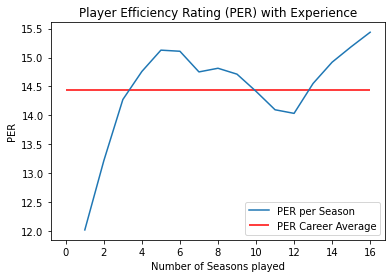

In [35]:
# visualize the PER development to decide for a veteran-experience-cutoff
total_player_stats[(total_player_stats.MP >= 10) & (total_player_stats.Age < 35)].groupby('Season_Number')['PER'].mean().plot()
plt.hlines(total_player_stats[(total_player_stats.MP >= 10) & (total_player_stats.Age < 35)].Career_PER.mean(), xmin=0, xmax=16, colors='red')
plt.title('Player Efficiency Rating (PER) with Experience')
plt.ylabel('PER')
plt.xlabel('Number of Seasons played')
plt.legend(['PER per Season', 'PER Career Average'])
plt.show()

This shows that the players mature within the first 5 years on average. So for our veteran selection it would be useful to take 5 seasons of experience as a cutoff for mature players who have reached their potential within their career - and since we want to predict the career potential with PER this should be fine.

In [36]:
# separate the rookies of this year from the veterans (>= 5 seasons NBA) we need for training 
veterans = total_player_stats[total_player_stats.Season_Number >= 5].namePlayer.to_list()
rookies = total_player_stats[(total_player_stats.Season_Number == 1) & (total_player_stats.Season == '2020-21')].namePlayer.to_list()

# get the correct players
total_player_stats_veterans = total_player_stats[total_player_stats.namePlayer.isin(veterans)]
total_player_stats_rookies = total_player_stats[total_player_stats.namePlayer.isin(rookies)]

# only keep the first season for training (Career PER included)
total_player_stats_veterans = total_player_stats_veterans[total_player_stats_veterans.Season_Number == 1]

# drop Season Number because it only carries 1.0 and Season because it doesn't hold valuable information for prediction
total_player_stats_rookies.drop(['Season_Number', 'Season'], axis=1, inplace=True)
total_player_stats_veterans.drop(['Season_Number', 'Season'], axis=1, inplace=True)

print(f'The veteran table for training has the shape: {total_player_stats_veterans.shape}')
print(f'The rookie table for prediction has the shape: {total_player_stats_rookies.shape}')

The veteran table for training has the shape: (507, 31)
The rookie table for prediction has the shape: (58, 31)


C:\Users\Kevin Götz\venv\nba_rookie\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [37]:
# Saving it to memory

# first the veterans
total_player_stats_veterans.reset_index(drop=True, inplace=True)
total_player_stats_veterans.to_csv('../Data/Output/NBA_Player_Stats_Veterans.csv')

# second the rookies
total_player_stats_rookies.reset_index(drop=True, inplace=True)
total_player_stats_rookies.to_csv('../Data/Output/NBA_Player_Stats_Rookies.csv')